In [ ]:
# Colab setup

# Setup NASLib
#%cd /content
#!git clone -b zerocost https://github.com/automl/NASLib/
#!pip install gdown

In [1]:
# Download zc score files
#%cd NASLib
#!source scripts/bash_scripts/download_nbs_zero.sh all
#%cd ..

In [1]:
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import os

from zc_combine.utils.naslib_utils import parse_scores, load_search_space
from zc_combine.ensemble.filter import common_n_largest, filter_by_zc_task
from zc_combine.utils.plot_utils import plot_common_networks, plot_accuracy_histogram, plot_top_quantile_zc, plot_networks_zc
from zc_combine.ensemble.eval import eval_zc

naslib_path = '../zero_cost/NASLib'

os.listdir(os.path.join(naslib_path, 'naslib/data/'))

['final5K_splits',
 'class_scene_selected.npy',
 'zc_transbench101_macro.json',
 'permutations_hamming_max_1000.npy',
 'zc_transbench101_micro.json',
 'zc_nasbench301.json',
 'zc_benchmarks',
 'zc_nasbench201.json',
 'taskonomydata_mini',
 'archs',
 'nb201_all.pickle',
 'zc_nasbench101.json',
 'class_object_selected.npy']

In [3]:
import pandas as pd


#TODO 90 %
def plot_filtered(dfs, filter_zc, rank_zc, key='tau', quantile=0.9, **kwargs):
  dfs_filter = filter_by_zc_task(dfs, filter_zc, quantile, **kwargs)
  dfs_filtered = eval_zc(dfs, rank_zc, filter_index=dfs_filter)

  qtitle = int(quantile * 100) if isinstance(quantile, float) else [int(q) for q in quantile]
  title = f"Nets over {qtitle}% quantile in {filter_zc}, {rank_zc} by validation accuracy."
  legend = [f'lower 90% nets by accuracy', f'top 10% nets by accuracy', 'best 3 networks']
  plot_networks_zc(dfs_filtered, rank_zc, title, subplots_adjust=0.9, legend=legend, legend_loc='lower right', key=key)
  plt.show()

  ranks = {t: {k: v for k, v in d['all'].items() if 'ranking' in k} for t, d in dfs_filtered.items()}
  stats = pd.DataFrame({t: {k: v for k, v in d['all'].items() if k != 'index' and 'ranking' not in k} for t, d in dfs_filtered.items()})
  return stats, ranks, dfs_filtered

# Transbench101 macro

In [4]:
what = 'zc_nasbench201'

zc_transbench101_macro = load_search_space(naslib_path, what)

In [5]:
dfs = parse_scores(zc_transbench101_macro)

Some tasks share only few best networks or none!

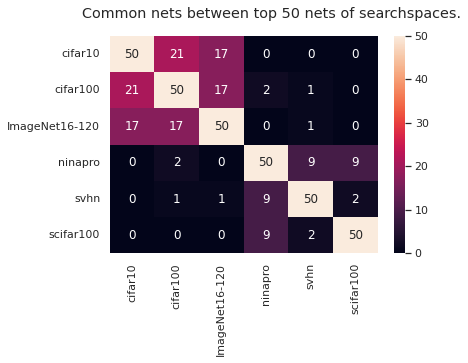

In [5]:
n_largest = 50
inds, common_nets = common_n_largest(dfs, n_largest=n_largest)

plot_common_networks(common_nets, inds, n_largest=n_largest)
plt.show()

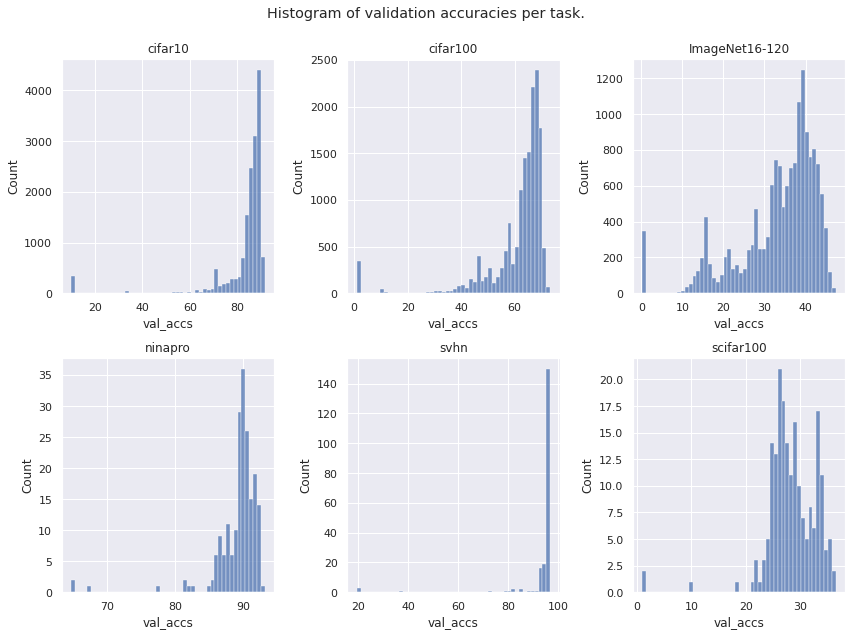

In [6]:
plot_accuracy_histogram(dfs)
plt.show()

/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabi/.env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/

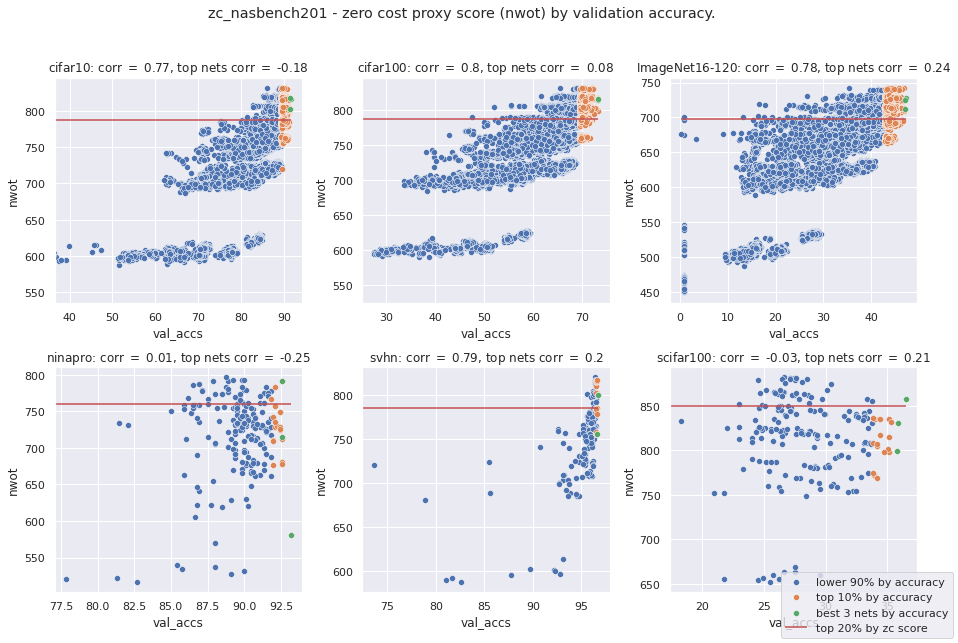

In [65]:
zc = 'nwot'

top_k = 3
acc_quantile = 0.9
zc_quantile = 0.8
dfs_stats = eval_zc(dfs, zc, top_k=top_k, acc_quantile=acc_quantile)

q = int(100 - acc_quantile * 100)
low_q = int(acc_quantile * 100)
zc_q = int(100 - zc_quantile * 100)

title = f"{what} - zero cost proxy score ({zc}) by validation accuracy."
legend = [f'lower {low_q}% by accuracy', f'top {q}% by accuracy', f'best {top_k} nets by accuracy', f'top {zc_q}% by zc score']
plot_networks_zc(dfs_stats, zc, title, top_line=True, subplots_adjust=0.87, legend=legend, legend_loc='lower right', zc_quantile=zc_quantile, key='corr',
                 figsize=(13, 9))
plt.show()

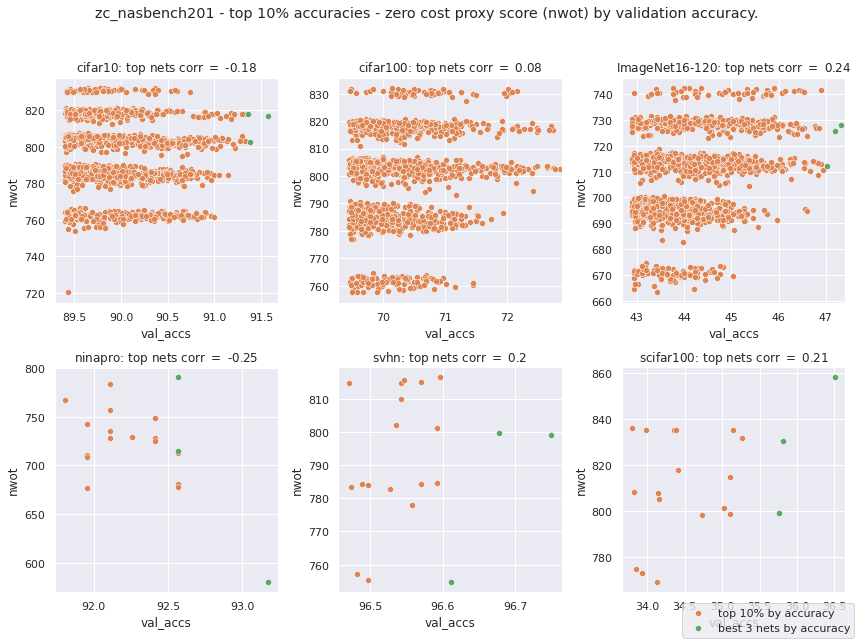

In [8]:
title = f"{what} - top {q}% accuracies - zero cost proxy score ({zc}) by validation accuracy."
legend = [f'top {q}% by accuracy', f'best {top_k} nets by accuracy']
plot_top_quantile_zc(dfs_stats, zc, title, subplots_adjust=0.87, legend=legend, legend_loc='lower right', zc_quantile=zc_quantile, key='corr')
plt.show()


# Combine two proxies

## Combine fisher and nwot

- fisher does not rank well top 10 % networks

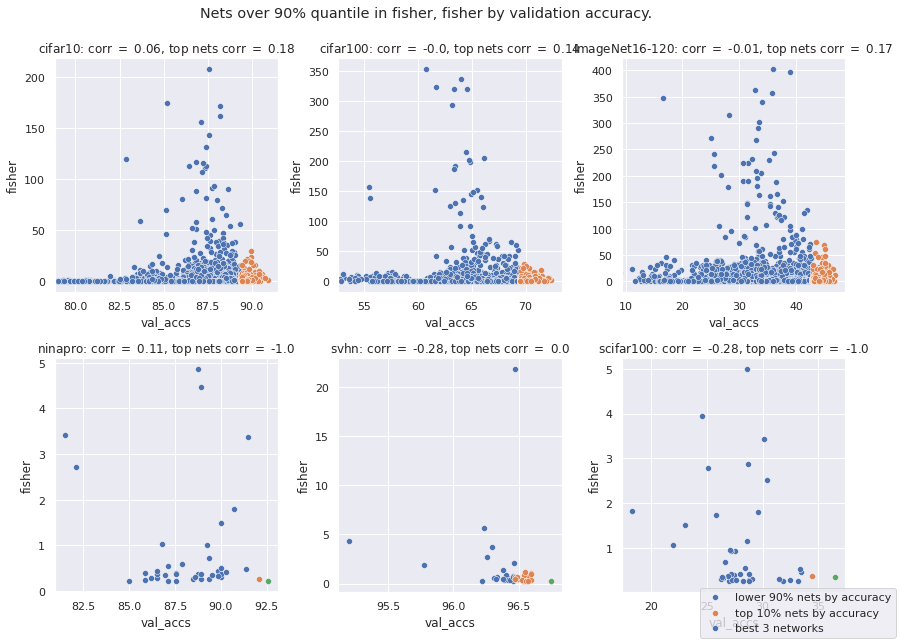

,cifar10,cifar100,ImageNet16-120,ninapro,svhn,scifar100
tau,0.050000,0.010000,-0.000000,0.080000,-0.200000,-0.190000
corr,0.060000,-0.000000,-0.010000,0.110000,-0.280000,-0.280000
acc_median,88.720000,68.520000,41.100000,88.770865,96.458205,28.119999
rank_median,11925.500000,12695.000000,12544.500000,50.500000,174.500000,100.000000
acc_median_drop,86.285000,64.270000,35.366667,90.136570,95.870467,28.169999
rank_median_drop,6762.000000,6811.500000,7171.500000,115.000000,83.000000,100.000000
acc_min,72.030000,42.840000,0.266667,81.487101,93.976644,18.319999
rank_min,1303.500000,805.000000,1.000000,6.000000,34.000000,4.000000
acc_min_drop,10.000000,1.000000,0.833333,64.795143,19.560541,1.000000
rank_min_drop,171.000000,1.500000,2.500000,1.500000,1.000000,1.000000


In [24]:
plot_filtered(dfs, 'fisher', 'fisher', quantile=0.8, key='corr')

- nwot is slightly better

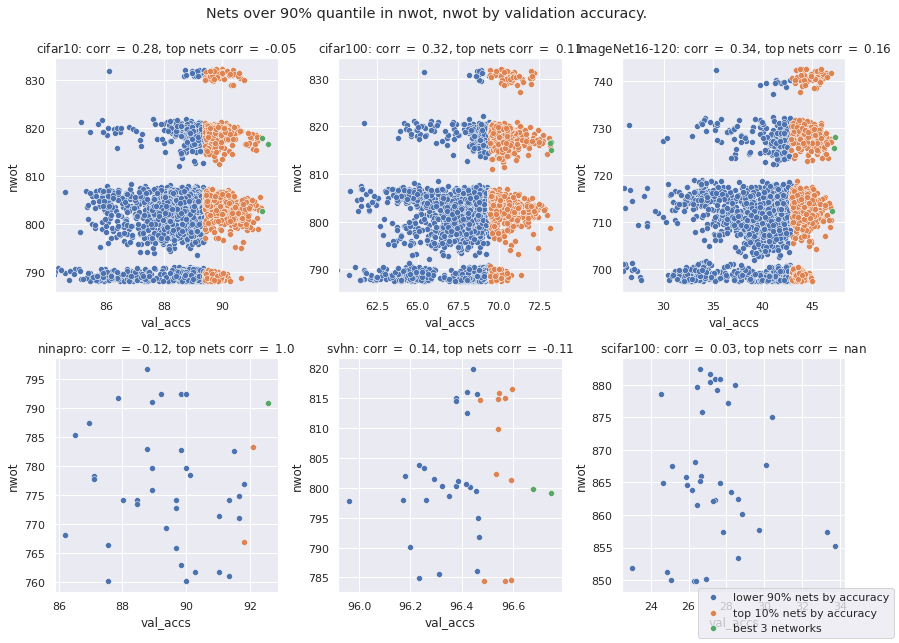

In [11]:
plot_filtered(dfs, 'nwot', 'nwot', quantile=0.8, key='corr')

- select top 10 % networks using fisher
- rank them using nwot
- performance is much better
   - compare with the fisher-fisher case above

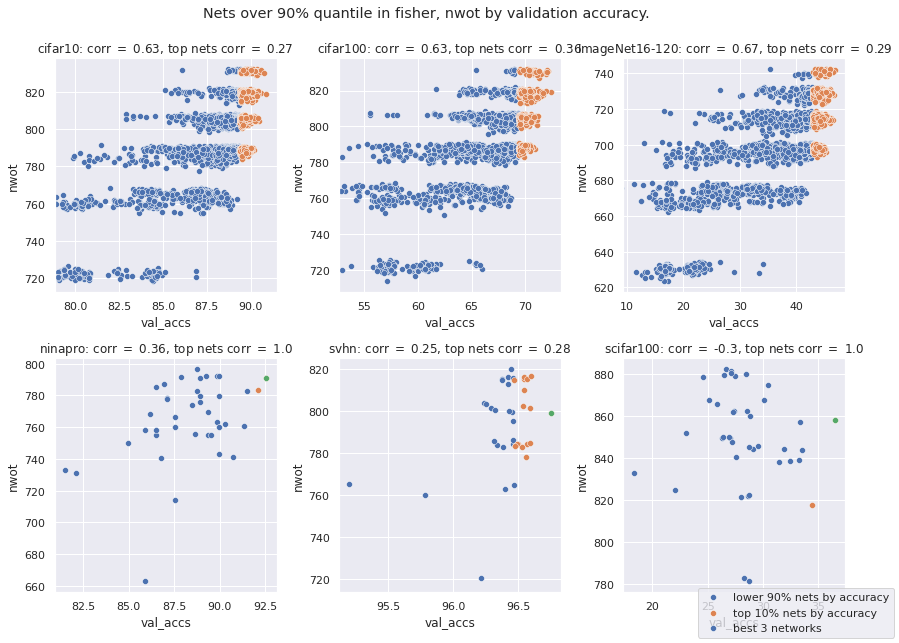

In [12]:
plot_filtered(dfs, 'fisher', 'nwot', quantile=0.8, key='corr')

- reversing the proxies leads to worse results

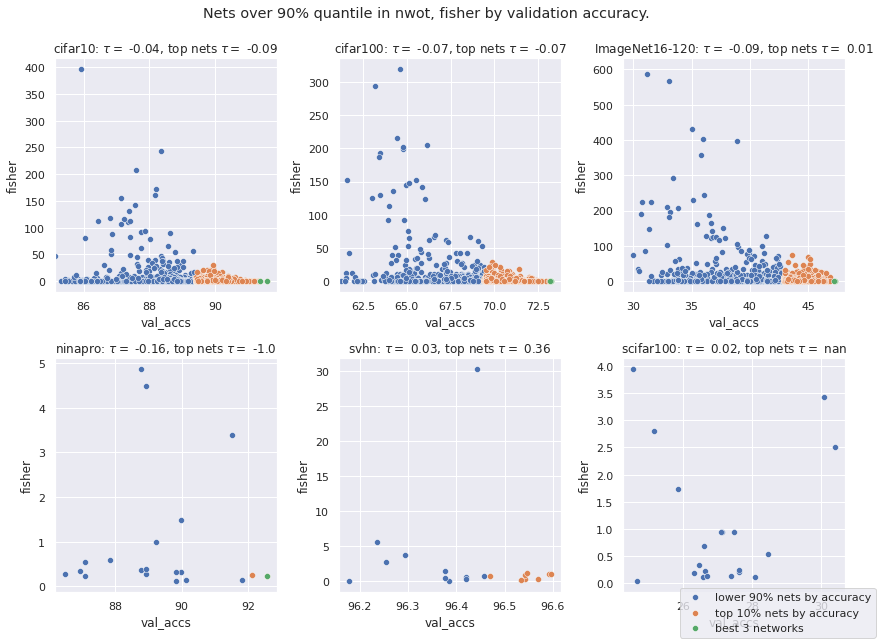

In [13]:
plot_filtered(dfs, 'nwot', 'fisher', quantile=0.9)

## Filter using multiple proxies

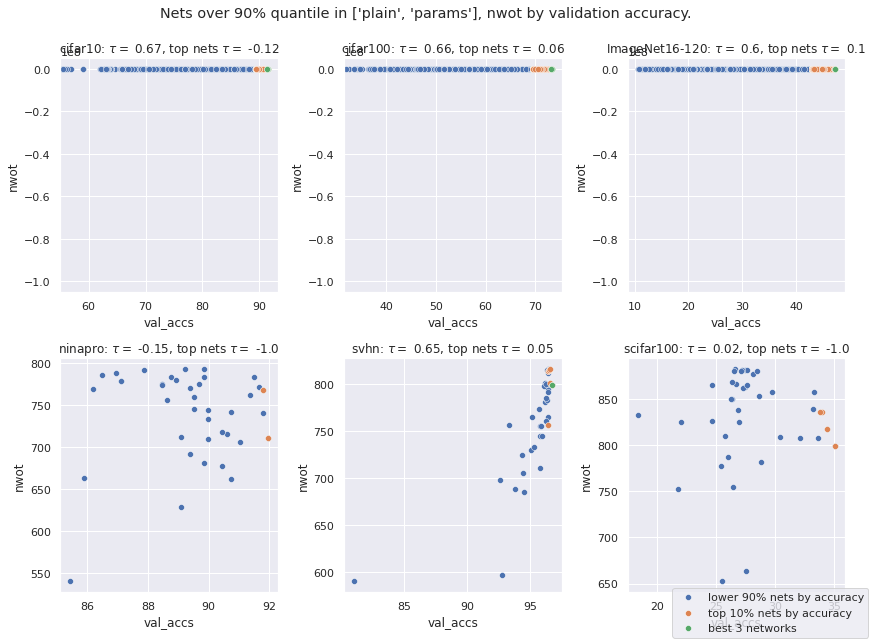

In [14]:
plot_filtered(dfs, ['plain', 'params'], 'nwot', mode='u')

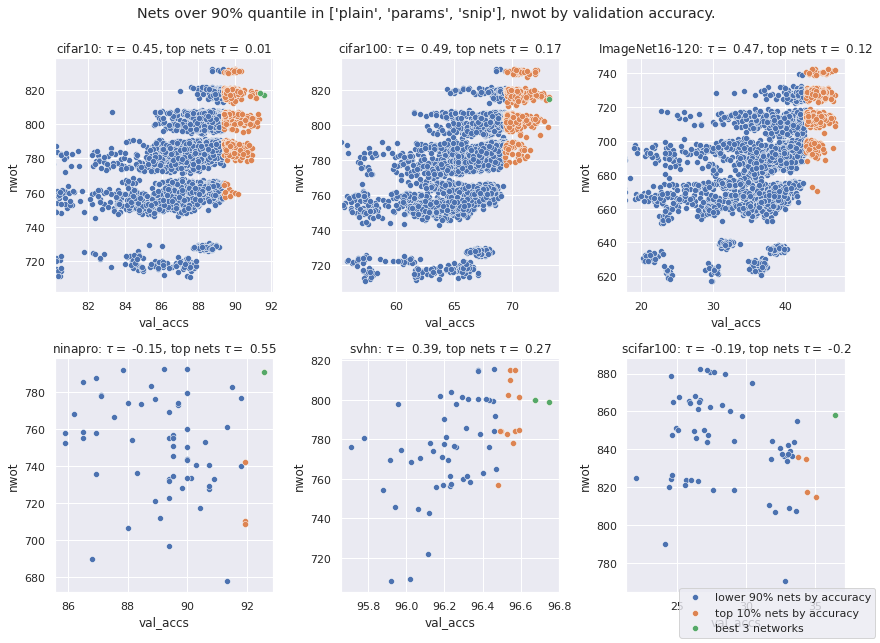

In [15]:
plot_filtered(dfs, ['plain', 'params', 'snip'], 'nwot', mode='s', quantile=[0.3, 0.3, 0.3])

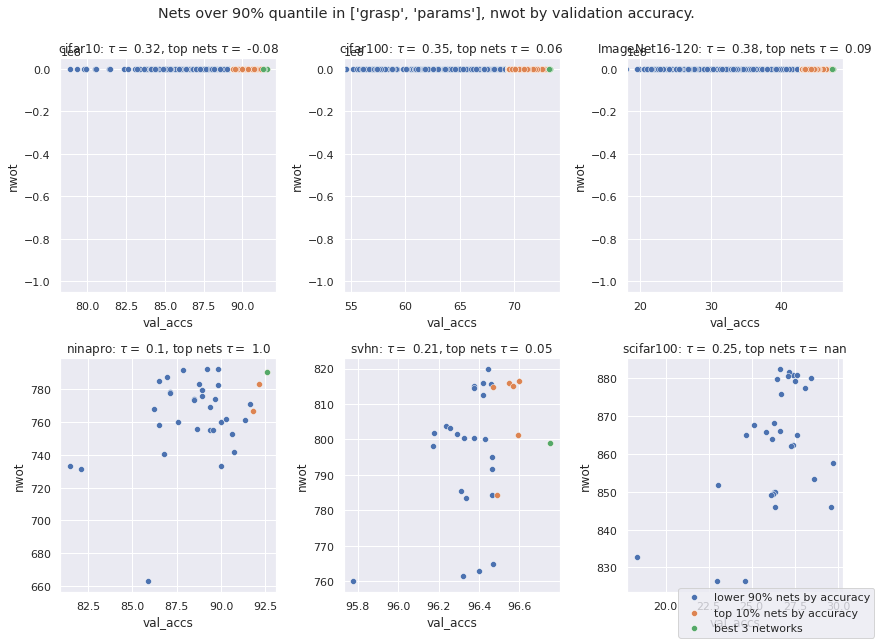

In [16]:
plot_filtered(dfs, ['grasp', 'params'], 'nwot', mode='u')

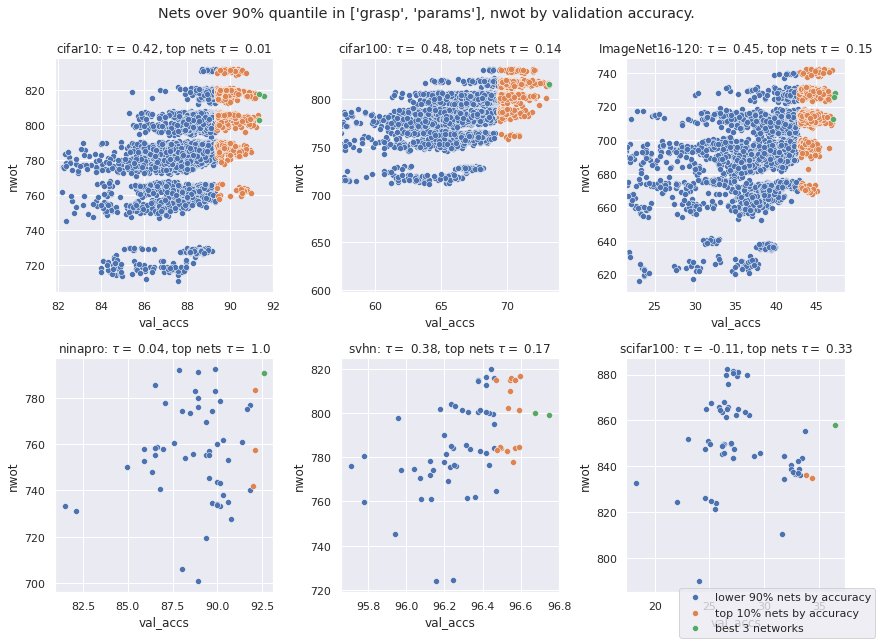

In [17]:
plot_filtered(dfs, ['grasp', 'params'], 'nwot', mode='i', quantile=0.5)

In [40]:
from zc_combine.ensemble.eval import eval_combined_proxies

proxies = [c for c in dfs['cifar10'].columns if c not in ['net', 'val_accs']]
inds, tau_scores = eval_combined_proxies(dfs, proxies, key='corr', zc_quantile=0.5)

In [41]:
tau_scores.keys()

dict_keys(['cifar10', 'cifar100', 'ImageNet16-120', 'ninapro', 'svhn', 'scifar100'])

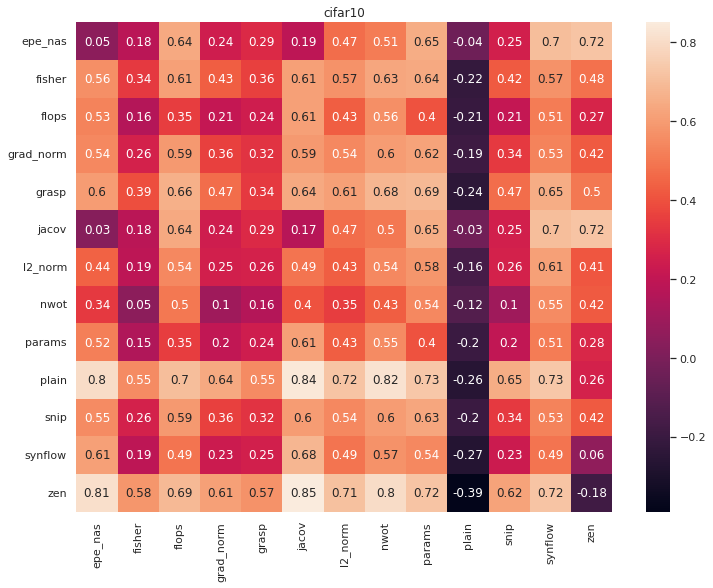

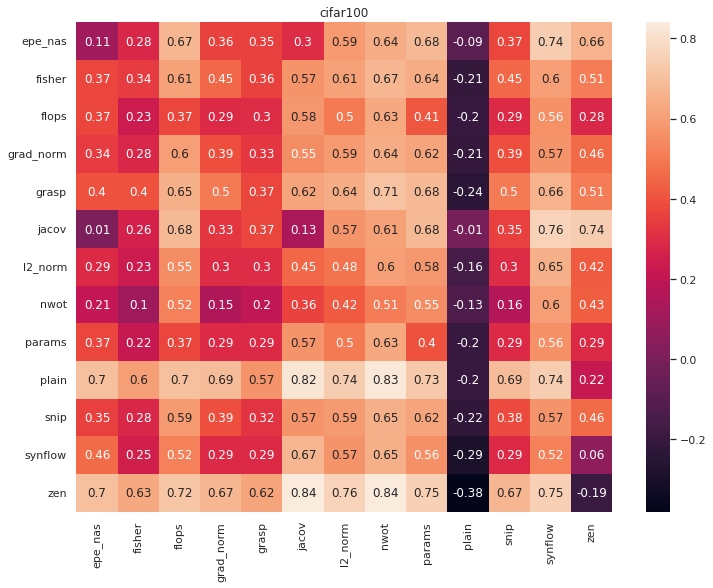

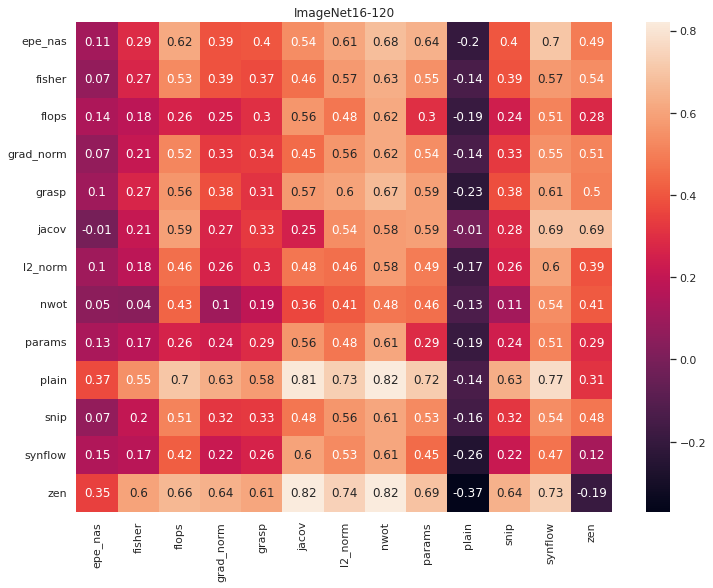

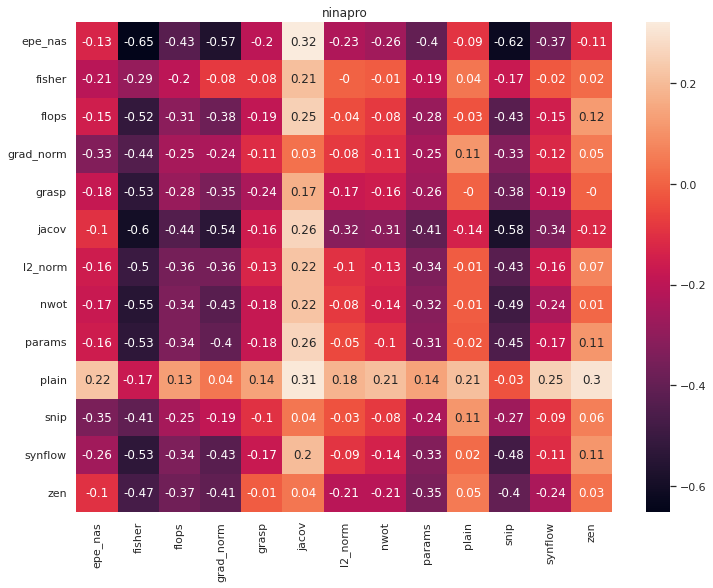

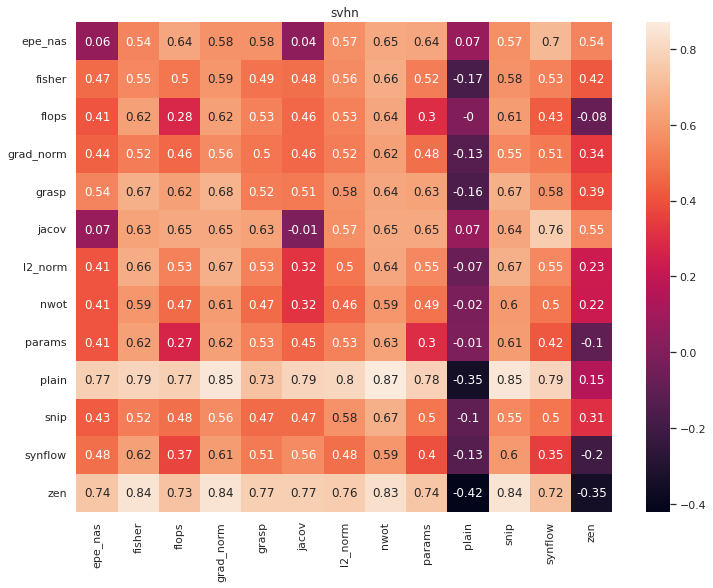

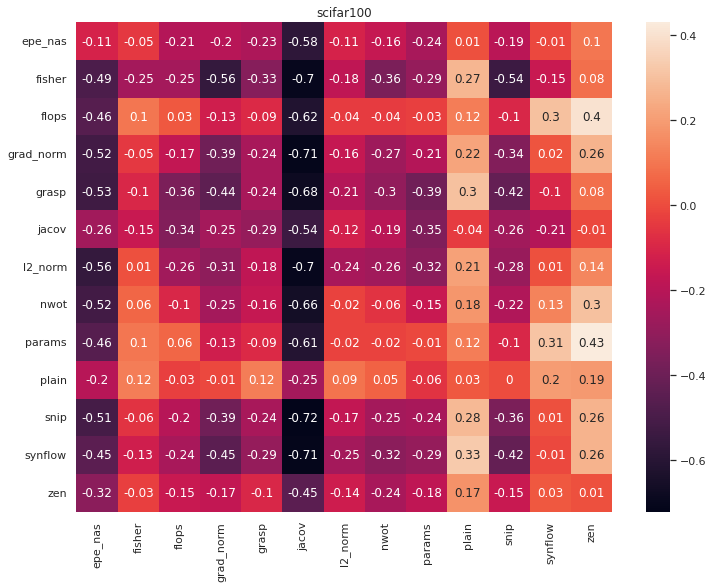

In [42]:
names = [inds[i] for i in range(len(inds))]

for k, v in tau_scores.items():
  plt.figure(figsize=(12,9))
  plt.title(k)
  sns.heatmap(tau_scores[k], annot=True, xticklabels=names, yticklabels=names)
  plt.show()

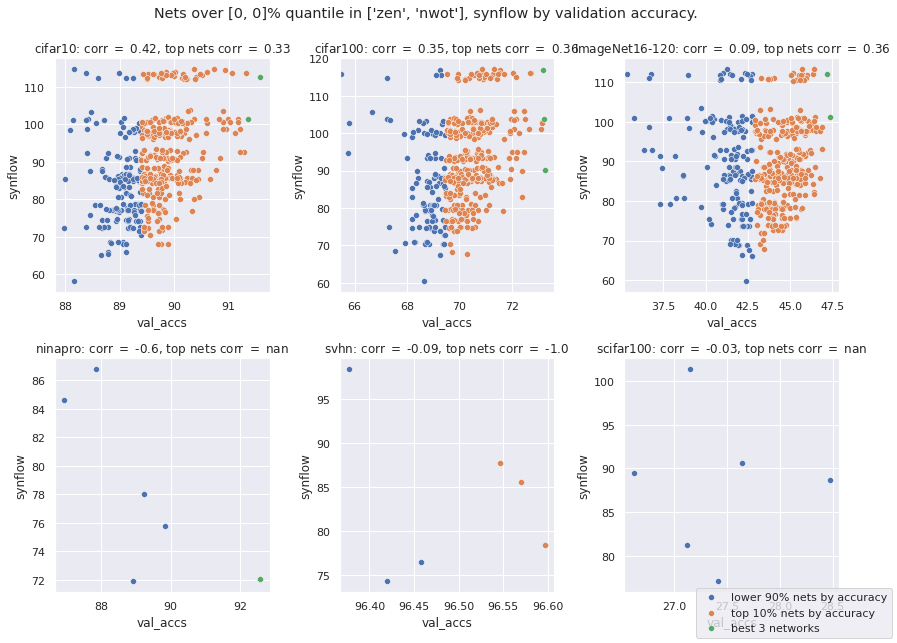

In [16]:
stats, ranks, dfilt = plot_filtered(dfs, ['zen', 'nwot'], 'synflow', quantile=[0.7, 0.9], key='corr', mode='s')

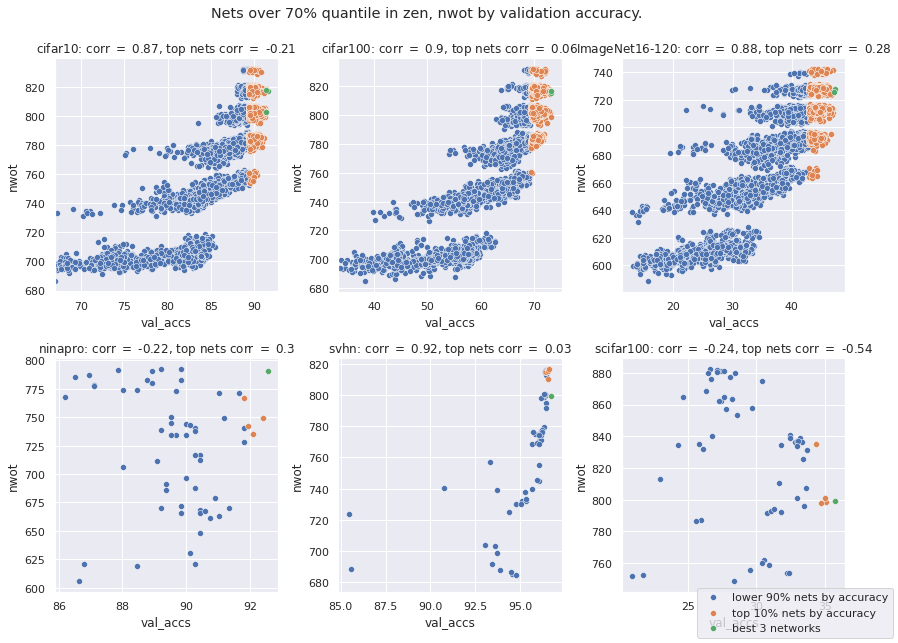

,cifar10,cifar100,ImageNet16-120,ninapro,svhn,scifar100
rank_median,6665.000000,6803.500000,6612.000000,102.000000,99.000000,61.50000
rank_median_drop,8051.000000,8115.500000,8192.500000,98.500000,101.000000,111.00000
rank_min,1.000000,1.000000,1.000000,3.000000,1.000000,3.00000
rank_min_drop,27.000000,105.000000,3.000000,1.000000,2.000000,1.00000
rank_mean,6955.740401,7008.489548,6780.207231,99.733333,102.058333,81.90000
rank_mean_drop,8180.452958,8157.842736,8255.692923,100.115108,99.111511,107.81295


In [66]:
#stats, ranks, dfilt = plot_filtered(dfs, 'zen', 'nwot', quantile=0.8, key='corr')
stats, ranks, dfilt = plot_filtered(dfs, 'zen', 'nwot', quantile=0.7, key='corr')
stats.loc[['rank_median', 'rank_median_drop', 'rank_min', 'rank_min_drop', 'rank_mean', 'rank_mean_drop']]

In [67]:
ranks['svhn'].keys()

dict_keys(['ranking_full', 'ranking_filter', 'ranking_drop'])

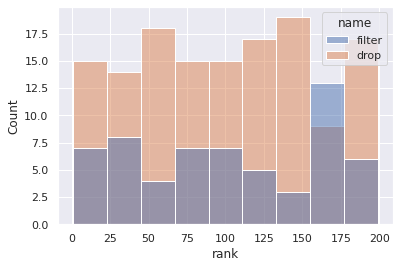

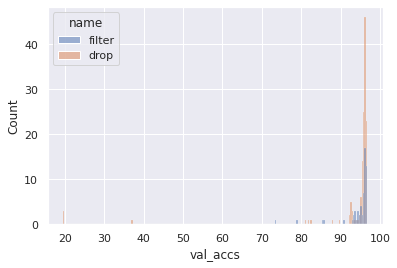

In [68]:
r = ranks['svhn']

r['ranking_filter']['name'] = 'filter'
r['ranking_drop']['name'] = 'drop'
rdata = pd.concat([r['ranking_filter'], r['ranking_drop']])

sns.histplot(data=rdata, x='rank', hue='name')
plt.show()

sns.histplot(data=rdata, x='val_accs', hue='name')
plt.show()

In [69]:
r['ranking_filter'].sort_values('rank')

,val_accs,rank,name
77,96.750154,1.0,filter
185,96.596497,4.0,filter
178,96.569607,7.5,filter
134,96.546558,10.0,filter
36,96.542717,12.0,filter
49,96.469730,20.0,filter
190,96.465888,22.0,filter
31,96.462047,23.0,filter
101,96.458205,25.5,filter
117,96.431315,31.0,filter


In [70]:
r['ranking_drop'].sort_values('rank')

,val_accs,rank,name
157,96.677167,2.0,drop
174,96.611862,3.0,drop
154,96.592655,5.0,drop
3,96.592655,6.0,drop
47,96.569607,7.5,drop
...,...,...,...
13,80.992624,193.0,drop
54,37.223417,196.0,drop
41,19.587431,197.5,drop
109,19.587431,197.5,drop


In [71]:
dfs['cifar10'].loc[6456]

net          (2, 3, 0, 2, 3, 2)
val_accs                  91.57
epe_nas             1756.764142
fisher                 0.018427
flops                124.126912
grad_norm             14.528912
grasp                  2.920427
jacov                -65.389701
l2_norm              282.939789
nwot                  816.72102
params                 0.858426
plain                  0.096632
snip                  30.142624
synflow              112.638228
zen                  159.187744
Name: 6456, dtype: object

In [21]:
dfilt['cifar10']['top_k']

{'k': 3, 'index': Int64Index([6456, 13588, 14151], dtype='int64')}

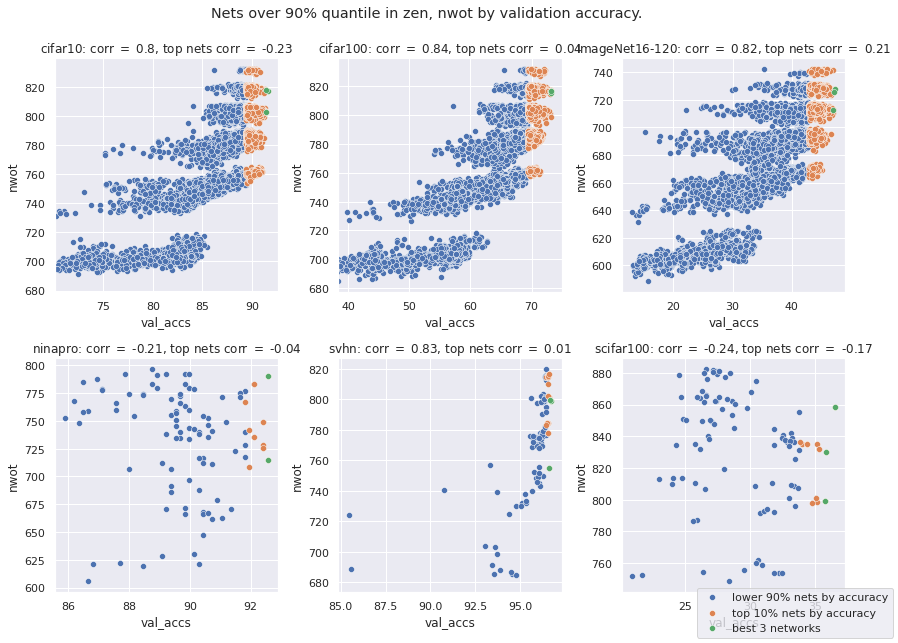

In [12]:
plot_filtered(dfs, 'zen', 'nwot', quantile=0.5, key='corr')  # TODO do correlation instead of tau

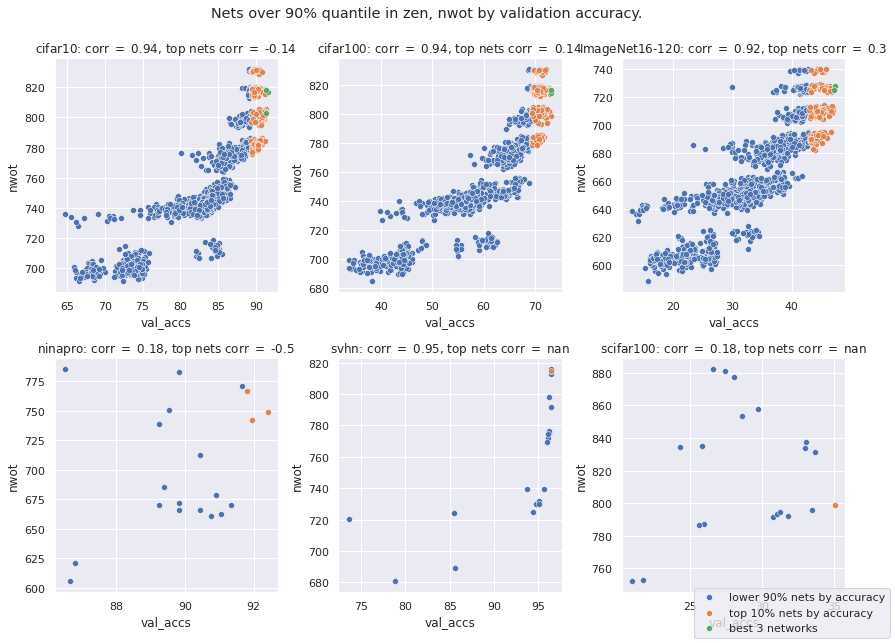

In [18]:
plot_filtered(dfs, 'zen', 'nwot', quantile=0.9, key='corr')  # TODO do correlation instead of tau

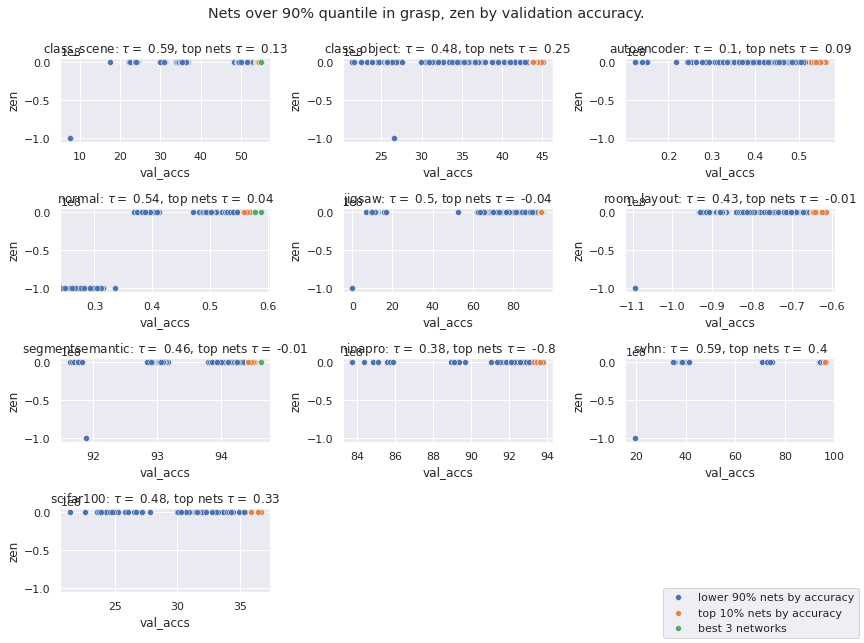

In [30]:
plot_filtered(dfs, 'grasp', 'zen', quantile=0.7)  # TODO do correlation instead of tau